# BERT
Use BERT Model with pretrained BERT tokenizer from huggingface.

## Import Packages and Environment Variables

In [1]:
import collections
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# import torchtext
import tqdm.auto as tqdm
import transformers
from sklearn.model_selection import train_test_split
import os

In [2]:
DATA_PATH = "data/"
DIR_PATH = os.getcwd()
TRAIN_DATA_PATH = os.path.join(DIR_PATH, DATA_PATH, "train.csv")
TEST_DATA_PATH = os.path.join(DIR_PATH, DATA_PATH, "test.csv")

VALIDATION_RATIO = 0.2
SEED = 1234

REMOVE_DUPLICATE = True
TRANSFORMER_NAME = 'bert-base-uncased'
BATCH_SIZE = 8

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

Using device: cuda:0


In [4]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
tqdm.tqdm.pandas()# enable progress_apply and progress_mapfor pandas

## Data Preprocessed and Feature Engineering

In [6]:
train_data = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)
train_data.head()

,review,sentiment
0,the single worst film i've ever seen in a thea...,negative
1,I was actually around 13 years old camping nea...,positive
2,A small town is attacked by a horde of bloodth...,negative
3,I think the problem with this show not getting...,positive
4,"Wow, this movie was horrible. As a Bills fan I...",negative


In [7]:
test.head()

,id,review
0,0,An expedition party made up of constantly bick...
1,1,"Well, I'll be honest: It is not exactly a Shol..."
2,2,"This is not a boring movie, the audience might..."
3,3,My boyfriend and I decided to go see this movi...
4,4,It's a shame this movie is rated PG 13--it is ...


In [8]:
# Remove Duplicated Data
if REMOVE_DUPLICATE:
    print(train_data.duplicated(subset=["review"]).sum())
    train_data.drop_duplicates(subset=["review"], inplace=True)
    train_data = train_data.reset_index(drop=True)

328


In [9]:
train_data["sentiment"] = train_data["sentiment"].progress_map(
    lambda x:1 if x == "positive" else 0
    )
train_data.head()

  0%|          | 0/39672 [00:00<?, ?it/s]

,review,sentiment
0,the single worst film i've ever seen in a thea...,0
1,I was actually around 13 years old camping nea...,1
2,A small town is attacked by a horde of bloodth...,0
3,I think the problem with this show not getting...,1
4,"Wow, this movie was horrible. As a Bills fan I...",0


In [10]:
# Tockenizer
tokenizer = transformers.BertTokenizer.from_pretrained(TRANSFORMER_NAME)

def tokenize_function(examples, tokenizer):
    return tokenizer(examples, truncation=True)["input_ids"] 

In [11]:
train_data["input_ids"] = train_data["review"].progress_map(lambda x :tokenize_function(x, tokenizer=tokenizer))
test["input_ids"] = test["review"].progress_map(lambda x :tokenize_function(x, tokenizer=tokenizer))    

  0%|          | 0/39672 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
train_data.head()

,review,sentiment,input_ids
0,the single worst film i've ever seen in a thea...,0,"[101, 1996, 2309, 5409, 2143, 1045, 1005, 2310..."
1,I was actually around 13 years old camping nea...,1,"[101, 1045, 2001, 2941, 2105, 2410, 2086, 2214..."
2,A small town is attacked by a horde of bloodth...,0,"[101, 1037, 2235, 2237, 2003, 4457, 2011, 1037..."
3,I think the problem with this show not getting...,1,"[101, 1045, 2228, 1996, 3291, 2007, 2023, 2265..."
4,"Wow, this movie was horrible. As a Bills fan I...",0,"[101, 10166, 1010, 2023, 3185, 2001, 9202, 101..."


In [13]:
test.head()

,id,review,input_ids
0,0,An expedition party made up of constantly bick...,"[101, 2019, 5590, 2283, 2081, 2039, 1997, 7887..."
1,1,"Well, I'll be honest: It is not exactly a Shol...","[101, 2092, 1010, 1045, 1005, 2222, 2022, 7481..."
2,2,"This is not a boring movie, the audience might...","[101, 2023, 2003, 2025, 1037, 11771, 3185, 101..."
3,3,My boyfriend and I decided to go see this movi...,"[101, 2026, 6898, 1998, 1045, 2787, 2000, 2175..."
4,4,It's a shame this movie is rated PG 13--it is ...,"[101, 2009, 1005, 1055, 1037, 9467, 2023, 3185..."


In [14]:
tokenizer.pad_token # Padding token

'[PAD]'

In [15]:
tokenizer.pad_token_id # Padding token id

0

In [16]:
# Use this index as padding value
pad_index = tokenizer.pad_token_id 

## Split trainning  set and validation set

In [17]:
train_data, valid_data = train_test_split(train_data, 
                                          test_size=VALIDATION_RATIO,
                                          random_state=SEED)
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

In [18]:
train_data.size, valid_data.size

(95211, 23805)

In [19]:
train_data.head()

,review,sentiment,input_ids
0,The evil bikie gang in this movie were called ...,0,"[101, 1996, 4763, 12170, 11602, 6080, 1999, 20..."
1,This movie was excellent for the following rea...,1,"[101, 2023, 3185, 2001, 6581, 2005, 1996, 2206..."
2,If there's one thing I've learnt from watching...,0,"[101, 2065, 2045, 1005, 1055, 2028, 2518, 1045..."
3,This movie tries to be more than it is. First ...,0,"[101, 2023, 3185, 5363, 2000, 2022, 2062, 2084..."
4,I understand this film to be a debut feature a...,1,"[101, 1045, 3305, 2023, 2143, 2000, 2022, 1037..."


## Dataset & DataLoader

In [20]:
class dataset(Dataset):
    """
    Custom dataset
    Args:
        data (pd.DataFrame): DataFrame containing 'input_ids' and 'sentiment' columns.
    """
    def __init__(self, data:pd.DataFrame):
        super().__init__()
        self.ids = data["input_ids"].to_list()
        self.labels = data["sentiment"].to_list()
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, ind):
        ids_tensor = torch.tensor(self.ids[ind], dtype=torch.int64)

        labels_tensor = torch.tensor(self.labels[ind], dtype=torch.int64)
        return ids_tensor, labels_tensor

### Make custon collate function for padding
Since the review length is different, we need to pad the input_ids to the same length in a batch.

In [21]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i[0] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i[1] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

### Create DataLoader

In [22]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=True):
    collate_fn = get_collate_fn(pad_index)
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )
    return data_loader

In [23]:
train_dataset = dataset(train_data)
valid_dataset = dataset(valid_data)

train_loader = get_data_loader(train_dataset, BATCH_SIZE, 
                               pad_index, shuffle=True)
valid_loader = get_data_loader(valid_dataset, BATCH_SIZE, 
                               pad_index, shuffle=False) 


## Model 
Build and Fine-tune the pre-trained model.

In [24]:
class Transformer(nn.Module):
    def __init__(self, transformer_name, num_classes, freeze):
        super().__init__()
        self.transformer = transformers.BertModel.from_pretrained(transformer_name)
        self.classifier = nn.Linear(self.transformer.config.hidden_size,
                                    num_classes)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, input_ids):
        outputs = self.transformer(input_ids=input_ids).last_hidden_state
        cls_output = outputs[:, 0, :]  # [CLS] token output
        logits = self.classifier(torch.tanh(cls_output))
        return logits

In [25]:
output_dim = len(train_data["sentiment"].unique())

In [26]:
model = Transformer(TRANSFORMER_NAME, output_dim, freeze=False)

## Trainning and Testing

### Trainning Setup

In [27]:
learning_rate = 1e-5
n_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
model = model.to(DEVICE)

## Trainning, Evaluating and Computing Accuracy

In [29]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [35]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


In [36]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [37]:
best_valid_loss = float("inf")

metrics = {"train_losses": [],
           "train_accs": [],
           "valid_losses": [],
           "valid_accs": []}

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_loader, model, criterion, optimizer, DEVICE
    )
    valid_loss, valid_acc = evaluate(valid_loader, model, criterion, DEVICE)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

training...:   0%|          | 0/3968 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/992 [00:00<?, ?it/s]

epoch: 0
train_loss: 0.118, train_acc: 0.959
valid_loss: 0.186, valid_acc: 0.935


training...:   0%|          | 0/3968 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/992 [00:00<?, ?it/s]

epoch: 1
train_loss: 0.059, train_acc: 0.981
valid_loss: 0.220, valid_acc: 0.932


training...:   0%|          | 0/3968 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/992 [00:00<?, ?it/s]

epoch: 2
train_loss: 0.034, train_acc: 0.989
valid_loss: 0.233, valid_acc: 0.937


### Plot

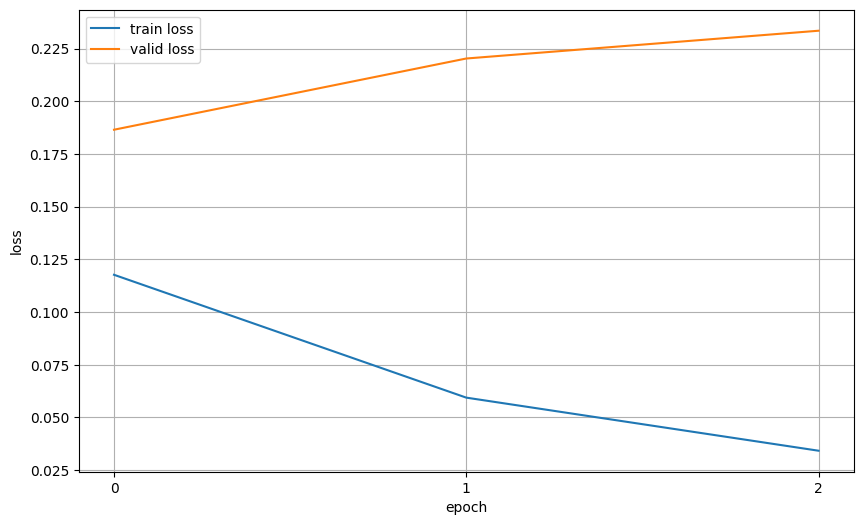

In [38]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

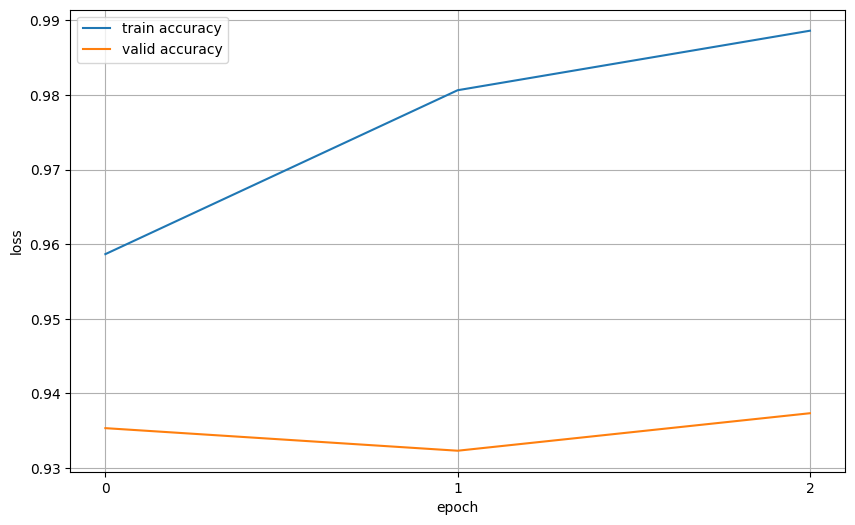

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

## Generate the test answer

In [44]:
class testDataset(Dataset):
    def __init__(self, data:pd.DataFrame):
        super().__init__()
        self.ids = data["input_ids"].to_list()
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, ind):
        ids_tensor = torch.tensor(self.ids[ind], dtype=torch.int64)
        return ids_tensor

In [45]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch = {"ids": batch_ids}
        return batch

    return collate_fn

In [46]:
def predict(data_loader, model, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="predicting..."):
            ids = batch["ids"].to(device)
            prediction = model(ids)
            preds.append(prediction)
    return torch.cat(preds)

In [48]:
# load the best model
model.load_state_dict(torch.load("transformer.pt"))
model = model.to(DEVICE)
test_dataset = testDataset(test)
test_loader = get_data_loader(test_dataset, BATCH_SIZE, 
                               pad_index, shuffle=False)
predictions = predict(test_loader, model, DEVICE)

predicting...:   0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
prediction_classes = predictions.argmax(dim=-1)
answer = pd.DataFrame({"id" : test["id"],
                       "sentiment": ["positive" if i == 1 else "negative" for i in prediction_classes.cpu().numpy()]})
answer.to_csv("submission.csv", index=False)